In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding coverage gap visualization

This notebook visualizes graph embeddings and highlights coverage gaps - argoverse graphs with nearly no corresponding carla data.

In [2]:
import os
os.getcwd()
os.chdir("../..")

In [3]:
from torch_geometric.data import Data
import numpy as np
from enum import Enum

import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader
from torch.utils.data import Subset

import torch
import torch.nn.functional as F
import os
import glob

import pickle
from tqdm import tqdm

# Create module alias for pickle compatibility (old pickles reference 'graph_creator' without 'src.' prefix)
import sys
import src.graph_creator
sys.modules['graph_creator'] = src.graph_creator

from src.graph_creator.MapGraph import MapGraph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from IPython.display import display, HTML
import json
# Using graph embeddings module with improved model architecture
from src.graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg
from src.graph_creator.plot_graphs import MapVisualizer

### Data prep

In [4]:
base_path = "/mnt/ssd_data/graph_coverage"
graph_setting = "graph_setting_1_50_50_10_20_20_4_4_4"
carla_graph_dir = f'actor_graphs/carla_actor_{graph_setting}'
argoverse_graph_dir = f'actor_graphs/argoverse_actor_{graph_setting}'

carla_graph_paths = glob.glob(f"{base_path}/{carla_graph_dir}_components_nx/*.pkl")
print(f"{base_path}/{carla_graph_dir}_components_nx")
print(f"Carla graphs: {len(carla_graph_paths)}")

/mnt/ssd_data/graph_coverage/actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx
Carla graphs: 202371


In [5]:
argoverse_graph_paths = glob.glob(f"{base_path}/{argoverse_graph_dir}_components_nx/*.pkl")
print(f"Argoverse graphs: {len(argoverse_graph_paths)}")

Argoverse graphs: 284752


In [6]:
# Combine all graph paths
graph_paths = carla_graph_paths.copy()
graph_paths.extend(argoverse_graph_paths)
print(f"Total graphs: {len(graph_paths)}")

Total graphs: 487123


### Load coverage gap data

In [7]:
# Load the coverage gap CSV file
coverage_gap_df = pd.read_csv("/home/tmuehlen/repos/graph_coverage/coverage_holes/carla_subgraph_holes.csv")
print(f"Coverage gap entries: {len(coverage_gap_df)}")
print(f"Unique scenarios: {coverage_gap_df['scenario'].nunique()}")
print(f"Scenarios: {coverage_gap_df['scenario'].unique()}")
coverage_gap_df.head()

Coverage gap entries: 31863
Unique scenarios: 4
Scenarios: ['cut_in' 'cut_out' 'lead_neighbor_opposite_vehicle_intersection'
 'cut_out_intersection']


scenario                               argoverse_graph_path  \
0   cut_in  actor_graphs/argoverse_actor_graph_setting_1_5...   
1   cut_in  actor_graphs/argoverse_actor_graph_setting_1_5...   
2   cut_in  actor_graphs/argoverse_actor_graph_setting_1_5...   
3   cut_in  actor_graphs/argoverse_actor_graph_setting_1_5...   
4   cut_in  actor_graphs/argoverse_actor_graph_setting_1_5...   

   argo_absolute_count  argo_relative_percentage  carla_absolute_count  \
0                22916                  7.602706                  1072   
1                22916                  7.602706                  1072   
2                22916                  7.602706                  1072   
3                22916                  7.602706                  1072   
4                22916                  7.602706                  1072   

   carla_relative_percentage  coverage_gap  
0                    0.53069        -21844  
1                    0.53069        -21844  
2                    0.53069        -21844  
3                    0.53069        -21844  
4                    0.53069        -21844

In [8]:
# Get unique scenarios
scenarios = coverage_gap_df['scenario'].unique().tolist()
print(f"Scenarios: {scenarios}")

# Build a mapping from filename to set of scenarios
filename_to_scenarios = {}
for _, row in coverage_gap_df.iterrows():
    filename = row['argoverse_graph_path'].split('/')[-1]
    scenario = row['scenario']
    if filename not in filename_to_scenarios:
        filename_to_scenarios[filename] = set()
    filename_to_scenarios[filename].add(scenario)

coverage_gap_filenames = set(filename_to_scenarios.keys())
print(f"Unique coverage gap graph filenames: {len(coverage_gap_filenames)}")

# Show scenario counts
print(f"\nScenario value counts:")
print(coverage_gap_df['scenario'].value_counts())

Scenarios: ['cut_in', 'cut_out', 'lead_neighbor_opposite_vehicle_intersection', 'cut_out_intersection']
Unique coverage gap graph filenames: 24524

Scenario value counts:
scenario
cut_in                                         22916
cut_out                                         7032
cut_out_intersection                            1555
lead_neighbor_opposite_vehicle_intersection      360
Name: count, dtype: int64


### ML prep

In [9]:
# Load all data into a single dataloader (no train/test split)
graph_ds = GraphDataset(graph_paths)

# Create a single loader with all data
all_loader = DataLoader(graph_ds, batch_size=128, shuffle=False, num_workers=16)

print(f"Total dataset size: {len(graph_ds)}")

# Test data loading
_item = graph_ds.__getitem__(0)
_batch = next(iter(all_loader))

Total dataset size: 487123


/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Load the checkpoint

In [10]:
# Find the latest checkpoint directory and load the best model
checkpoint_base_dir = "/home/tmuehlen/repos/graph_coverage/checkpoints"

# Get all checkpoint directories sorted by name (timestamp format ensures chronological order)
checkpoint_dirs = sorted([d for d in os.listdir(checkpoint_base_dir) 
                          if os.path.isdir(os.path.join(checkpoint_base_dir, d))])

# Find the latest directory that has a best_model.pt file
latest_checkpoint_dir = None
for d in reversed(checkpoint_dirs):
    best_model_path = os.path.join(checkpoint_base_dir, d, "best_model.pt")
    if os.path.exists(best_model_path):
        latest_checkpoint_dir = d
        break

if latest_checkpoint_dir is None:
    raise FileNotFoundError("No checkpoint directory with best_model.pt found!")

checkpoint_path = os.path.join(checkpoint_base_dir, latest_checkpoint_dir)
config_path = os.path.join(checkpoint_path, "config.json")
best_model_path = os.path.join(checkpoint_path, "best_model.pt")

print(f"Using checkpoint directory: {latest_checkpoint_dir}")
print(f"Best model path: {best_model_path}")

# Load config
with open(config_path, 'r') as f:
    config = json.load(f)

# Extract model parameters
hidden_dim = config['model']['hidden_dim']
embedding_dim = config['model'].get('embedding_dim', config['model'].get('output_dim', 256))
num_layers = config['model']['num_layers']

print(f"\nModel configuration:")
print(f"  hidden_dim: {hidden_dim}")
print(f"  embedding_dim: {embedding_dim}")
print(f"  num_layers: {num_layers}")

Using checkpoint directory: 20260123_101713
Best model path: /home/tmuehlen/repos/graph_coverage/checkpoints/20260123_101713/best_model.pt

Model configuration:
  hidden_dim: 384
  embedding_dim: 192
  num_layers: 5


In [11]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
node_dim, edge_dim = get_feature_dimensions()

model = TrainableGraphGINE(
    node_dim, 
    edge_dim, 
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim, 
    num_layers=num_layers
).to(device)

print(f"Model created with node_dim={node_dim}, edge_dim={edge_dim}")
print(f"Embedding dimension: {embedding_dim}")

Model created with node_dim=7, edge_dim=7
Embedding dimension: 192


In [12]:
# Load the best model checkpoint
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Display checkpoint info
print(f"Loaded checkpoint from: {best_model_path}")
if 'best_test_loss' in checkpoint:
    print(f"Best test loss: {checkpoint['best_test_loss']:.4f}")
if 'loop' in checkpoint and 'epoch' in checkpoint:
    print(f"From loop {checkpoint['loop']}, epoch {checkpoint['epoch']}")

/tmp/ipykernel_800040/622228002.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


Loaded checkpoint from: /home/tmuehlen/repos/graph_coverage/checkpoints/20260123_101713/best_model.pt
Best test loss: 0.0291
From loop 13, epoch 3


### Inference on all data

In [13]:
# Inference loop
model.eval()
all_embeddings = []
all_paths = []

with torch.no_grad():
    for batch in tqdm(all_loader):
        all_paths.extend(batch[1]) 
        batch = batch[0].to(device)
        outputs = model(batch)
        embeddings = outputs['embeddings']
        all_embeddings.append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = torch.cat(all_embeddings, dim=0)

print(f'Extracted {final_embeddings.shape[0]} embeddings of dimension {final_embeddings.shape[1]}')

100%|██████████| 3806/3806 [00:46<00:00, 81.95it/s] 


Extracted 487123 embeddings of dimension 192


### Visualization of embeddings

In [14]:
# Data preparation
graph_type = [path.split("/")[-2].split("_")[0] for path in all_paths]

# Mark coverage gap graphs and scenario membership
is_coverage_gap = []
scenario_flags = {scenario: [] for scenario in scenarios}

for path in all_paths:
    filename = path.split('/')[-1]
    is_gap = filename in coverage_gap_filenames
    is_coverage_gap.append(is_gap)
    
    # Check which scenarios this graph belongs to
    graph_scenarios = filename_to_scenarios.get(filename, set())
    for scenario in scenarios:
        scenario_flags[scenario].append(scenario in graph_scenarios)

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

dim_reduc_df = pd.DataFrame(pca_result)
dim_reduc_df.columns = ["pca1", "pca2"]
dim_reduc_df["graph_type"] = graph_type
dim_reduc_df["graph_path"] = all_paths
dim_reduc_df["is_coverage_gap"] = is_coverage_gap

# Add scenario columns
for scenario in scenarios:
    dim_reduc_df[scenario] = scenario_flags[scenario]

print(f"Total graphs: {len(dim_reduc_df)}")
print(f"Coverage gap graphs: {sum(is_coverage_gap)}")
print(f"\nScenario columns added: {scenarios}")
dim_reduc_df.head()

Total graphs: 487123
Coverage gap graphs: 23148

Scenario columns added: ['cut_in', 'cut_out', 'lead_neighbor_opposite_vehicle_intersection', 'cut_out_intersection']


pca1      pca2 graph_type  \
0  0.378206  0.518580      carla   
1  0.395993  0.427380      carla   
2  0.204751  0.281480      carla   
3  0.337795  0.349474      carla   
4  0.373435  0.409985      carla   

                                          graph_path  is_coverage_gap  cut_in  \
0  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
1  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
2  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
3  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
4  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   

   cut_out  lead_neighbor_opposite_vehicle_intersection  cut_out_intersection  
0    False                                        False                 False  
1    False                                        False                 False  
2    False                                        False                 False  
3    False                                        False                 False  
4    False                                        False                 False

In [15]:
print("Graph type distribution:")
print(pd.Series(graph_type).value_counts())
print(f"\nCoverage gap distribution:")
print(dim_reduc_df['is_coverage_gap'].value_counts())
print(f"\nScenario distributions:")
for scenario in scenarios:
    print(f"  {scenario}: {dim_reduc_df[scenario].sum()}")

Graph type distribution:
argoverse    284752
carla        202371
Name: count, dtype: int64

Coverage gap distribution:
is_coverage_gap
False    463975
True      23148
Name: count, dtype: int64

Scenario distributions:
  cut_in: 21643
  cut_out: 6653
  lead_neighbor_opposite_vehicle_intersection: 330
  cut_out_intersection: 1462


In [16]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=250, verbose=1)
tsne_result = tsne.fit_transform(embeddings_np)
dim_reduc_df["tsne1"] = tsne_result[:, 0]
dim_reduc_df["tsne2"] = tsne_result[:, 1]
dim_reduc_df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 487123 samples in 0.029s...
[t-SNE] Computed neighbors for 487123 samples in 169.426s...
[t-SNE] Computed conditional probabilities for sample 1000 / 487123
[t-SNE] Computed conditional probabilities for sample 2000 / 487123
[t-SNE] Computed conditional probabilities for sample 3000 / 487123
[t-SNE] Computed conditional probabilities for sample 4000 / 487123
[t-SNE] Computed conditional probabilities for sample 5000 / 487123
[t-SNE] Computed conditional probabilities for sample 6000 / 487123
[t-SNE] Computed conditional probabilities for sample 7000 / 487123
[t-SNE] Computed conditional probabilities for sample 8000 / 487123
[t-SNE] Computed conditional probabilities for sample 9000 / 487123
[t-SNE] Computed conditional probabilities for sample 10000 / 487123
[t-SNE] Computed conditional probabilities for sample 11000 / 487123
[t-SNE] Computed conditional probabilities for sample 12000 / 487123
[t-SNE] Computed conditional proba

pca1      pca2 graph_type  \
0  0.378206  0.518580      carla   
1  0.395993  0.427380      carla   
2  0.204751  0.281480      carla   
3  0.337795  0.349474      carla   
4  0.373435  0.409985      carla   

                                          graph_path  is_coverage_gap  cut_in  \
0  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
1  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
2  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
3  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   
4  /mnt/ssd_data/graph_coverage/actor_graphs/carl...            False   False   

   cut_out  lead_neighbor_opposite_vehicle_intersection  cut_out_intersection  \
0    False                                        False                 False   
1    False                                        False                 False   
2    False                                        False                 False   
3    False                                        False                 False   
4    False                                        False                 False   

      tsne1     tsne2  
0  5.337377  2.627349  
1  4.346338  3.327810  
2  0.061138  2.490239  
3  3.544716  1.962802  
4  3.138442  1.216534

### Visualization with coverage gaps highlighted

In [17]:
# Split data for plotting
df_normal = dim_reduc_df[~dim_reduc_df['is_coverage_gap']]
df_gap = dim_reduc_df[dim_reduc_df['is_coverage_gap']]

print(f"df_gap has {len(df_gap)} rows")
print(f"df_gap scenario columns:")
for scenario in scenarios:
    print(f"  {scenario}: {df_gap[scenario].sum()}")

df_gap has 23148 rows
df_gap scenario columns:
  cut_in: 21643
  cut_out: 6653
  lead_neighbor_opposite_vehicle_intersection: 330
  cut_out_intersection: 1462


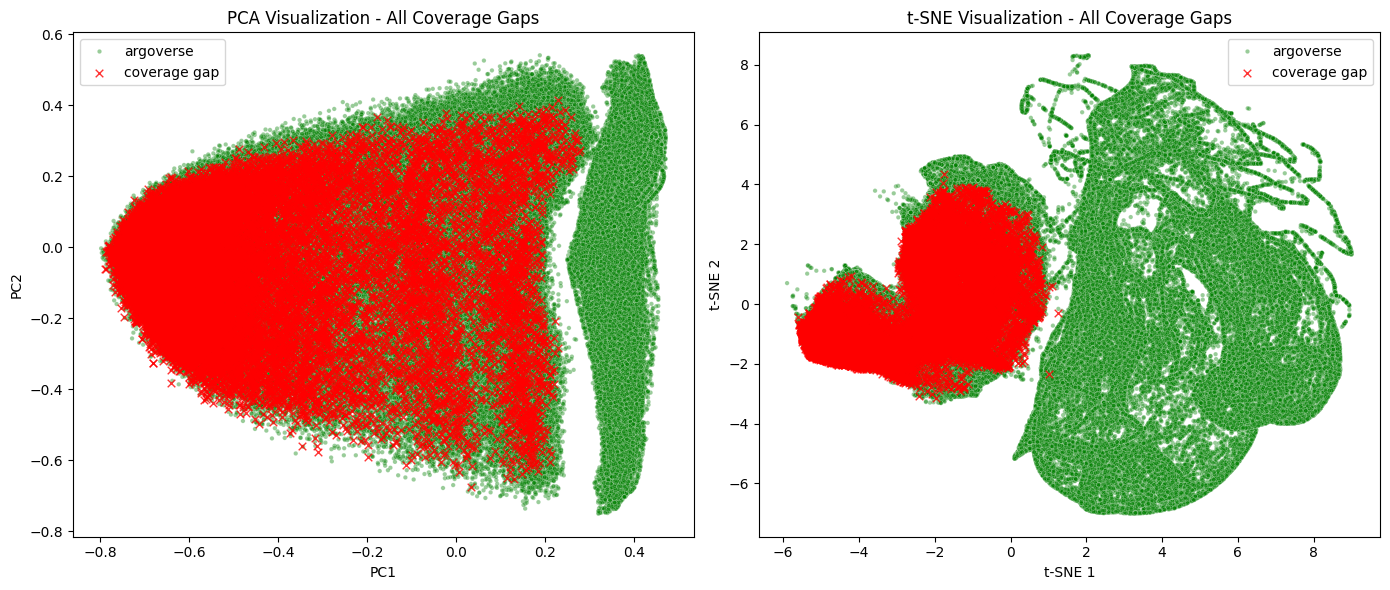

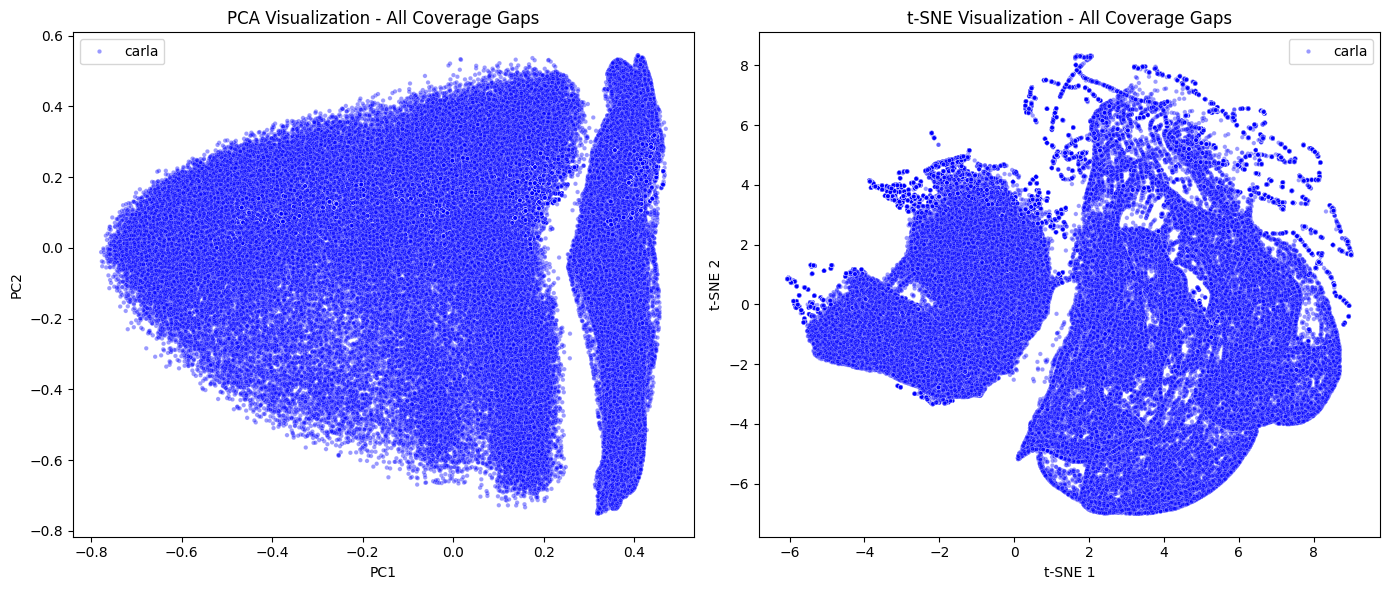

In [18]:
# Combined plot with all coverage gaps
plt.figure(figsize=(14, 6))

# PCA plot
plt.subplot(1, 2, 1)
# Plot normal points first (background)
sns.scatterplot(x="pca1", y="pca2", alpha=0.4, hue="graph_type", 
                data=df_normal[df_normal.graph_type == "argoverse"], s=10, palette={"carla": "blue", "argoverse": "green"})
# Overlay coverage gap points with different marker
plt.scatter(df_gap["pca1"], df_gap["pca2"], c="red", s=30, marker="x", 
            label="coverage gap", alpha=0.8, linewidths=1)
plt.title('PCA Visualization - All Coverage Gaps')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# t-SNE plot
plt.subplot(1, 2, 2)
# Plot normal points first (background)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.4, hue="graph_type", 
                data=df_normal[df_normal.graph_type == "argoverse"], s=10, palette={"carla": "blue", "argoverse": "green"})
# Overlay coverage gap points with different marker
plt.scatter(df_gap["tsne1"], df_gap["tsne2"], c="red", s=30, marker="x", 
            label="coverage gap", alpha=0.8, linewidths=1)
plt.title('t-SNE Visualization - All Coverage Gaps')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()

plt.tight_layout()
plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_coverage_gap_visualization_just_argo.png", dpi=150)
plt.show()

plt.figure(figsize=(14, 6))

# PCA plot
plt.subplot(1, 2, 1)
# Plot normal points first (background)
sns.scatterplot(x="pca1", y="pca2", alpha=0.4, hue="graph_type", 
                data=df_normal[df_normal.graph_type == "carla"], s=10, palette={"carla": "blue", "argoverse": "green"})
plt.title('PCA Visualization - All Coverage Gaps')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# t-SNE plot
plt.subplot(1, 2, 2)
# Plot normal points first (background)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.4, hue="graph_type", 
                data=df_normal[df_normal.graph_type == "carla"], s=10, palette={"carla": "blue", "argoverse": "green"})
# Overlay coverage gap points with different marker
plt.title('t-SNE Visualization - All Coverage Gaps')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()

plt.tight_layout()
plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_coverage_gap_visualization_just_carla.png", dpi=150)
plt.show()

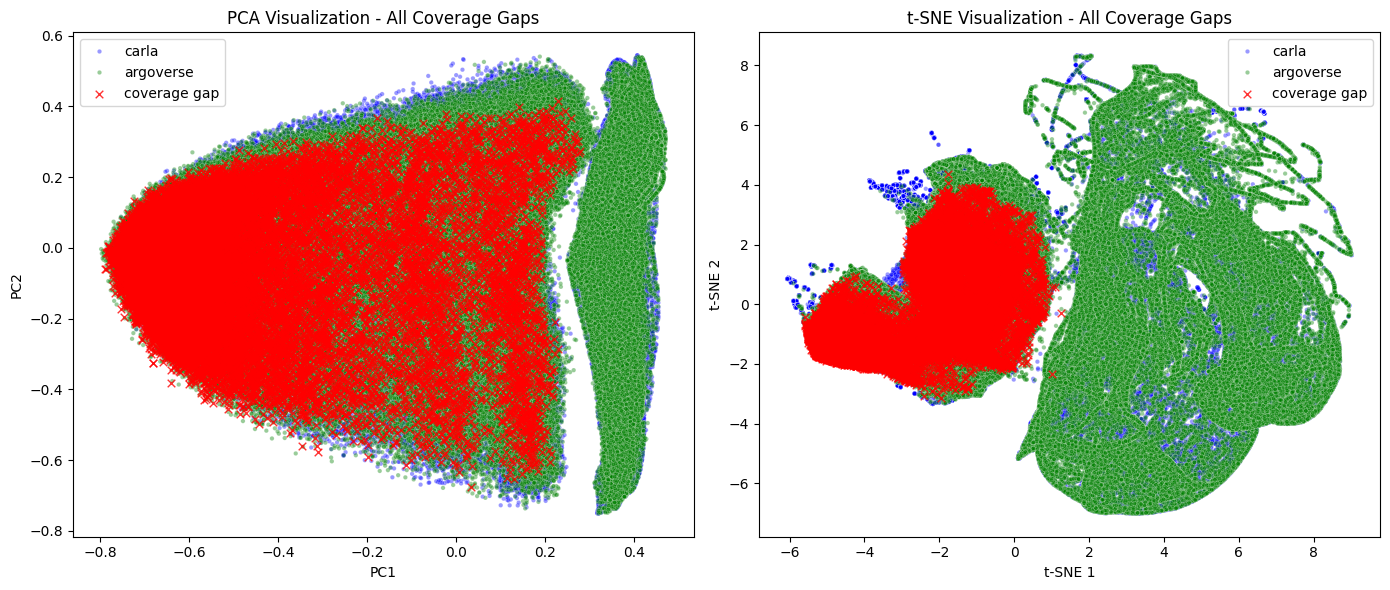

In [19]:
# Combined plot with all coverage gaps
plt.figure(figsize=(14, 6))

# PCA plot
plt.subplot(1, 2, 1)
# Plot normal points first (background)
sns.scatterplot(x="pca1", y="pca2", alpha=0.4, hue="graph_type", 
                data=df_normal, s=10, palette={"carla": "blue", "argoverse": "green"})
# Overlay coverage gap points with different marker
plt.scatter(df_gap["pca1"], df_gap["pca2"], c="red", s=30, marker="x", 
            label="coverage gap", alpha=0.8, linewidths=1)
plt.title('PCA Visualization - All Coverage Gaps')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# t-SNE plot
plt.subplot(1, 2, 2)
# Plot normal points first (background)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.4, hue="graph_type", 
                data=df_normal, s=10, palette={"carla": "blue", "argoverse": "green"})
# Overlay coverage gap points with different marker
plt.scatter(df_gap["tsne1"], df_gap["tsne2"], c="red", s=30, marker="x", 
            label="coverage gap", alpha=0.8, linewidths=1)
plt.title('t-SNE Visualization - All Coverage Gaps')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()

plt.tight_layout()
plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_coverage_gap_visualization.png", dpi=150)
plt.show()

### Visualization by scenario type

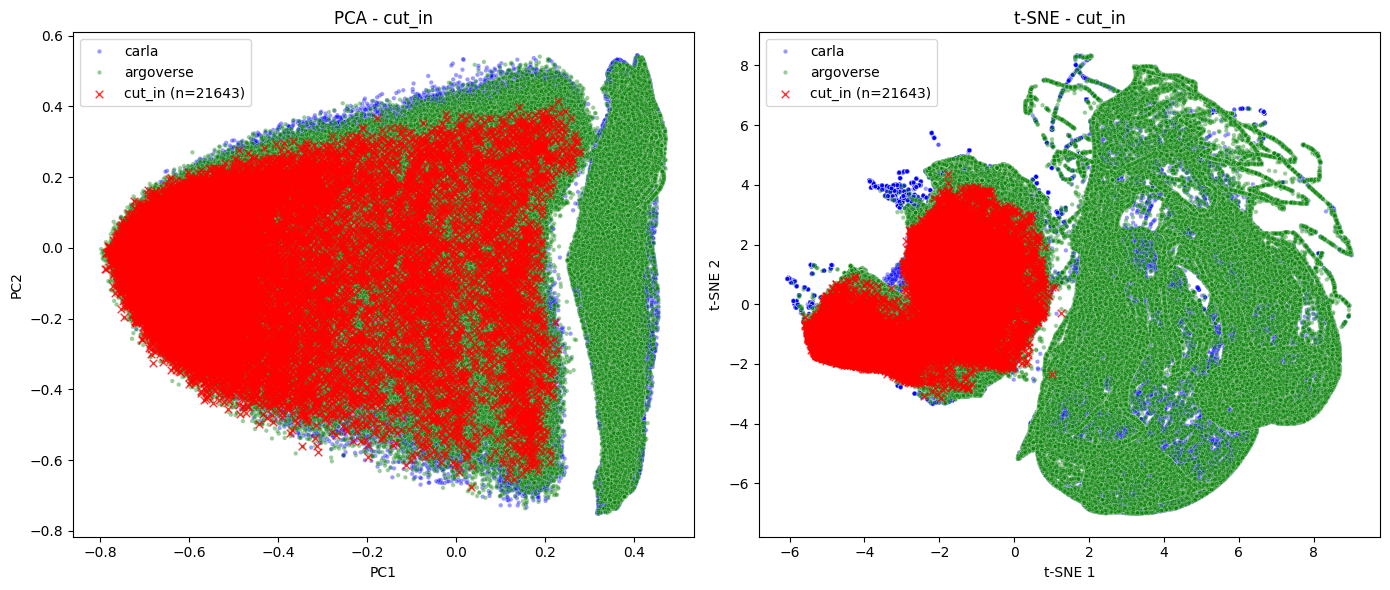

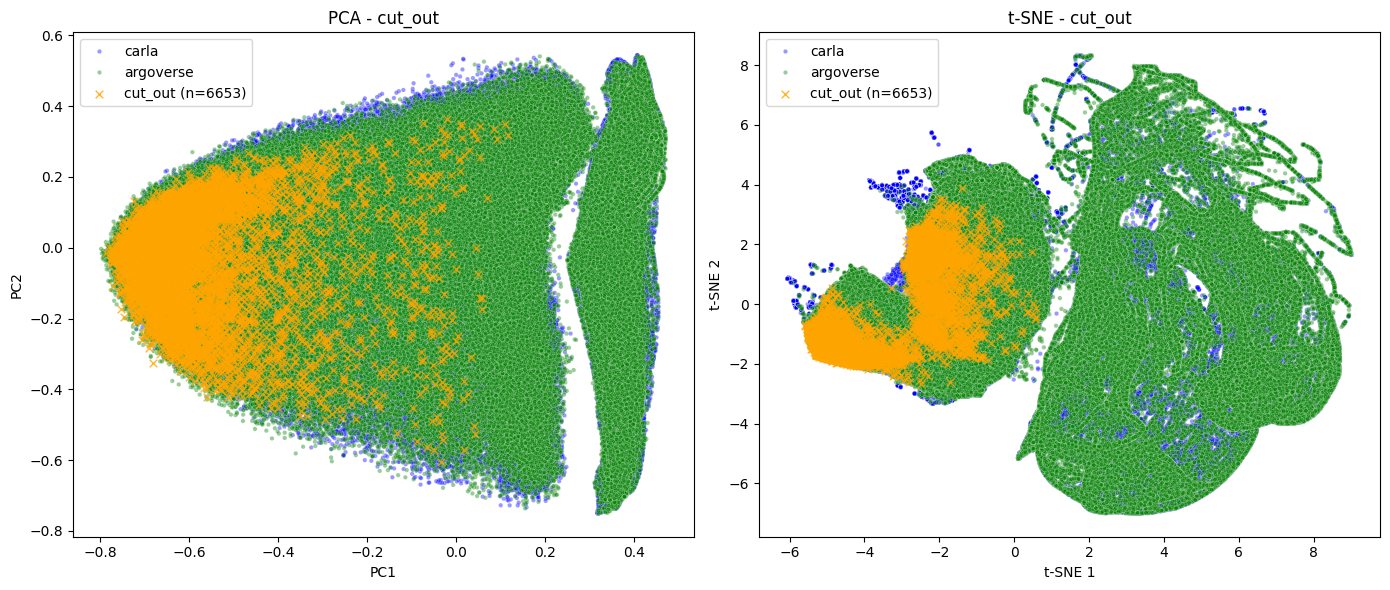

/tmp/ipykernel_800040/4167358975.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_800040/4167358975.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_coverage_gap_{safe_scenario_name}.png", dpi=150)
/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


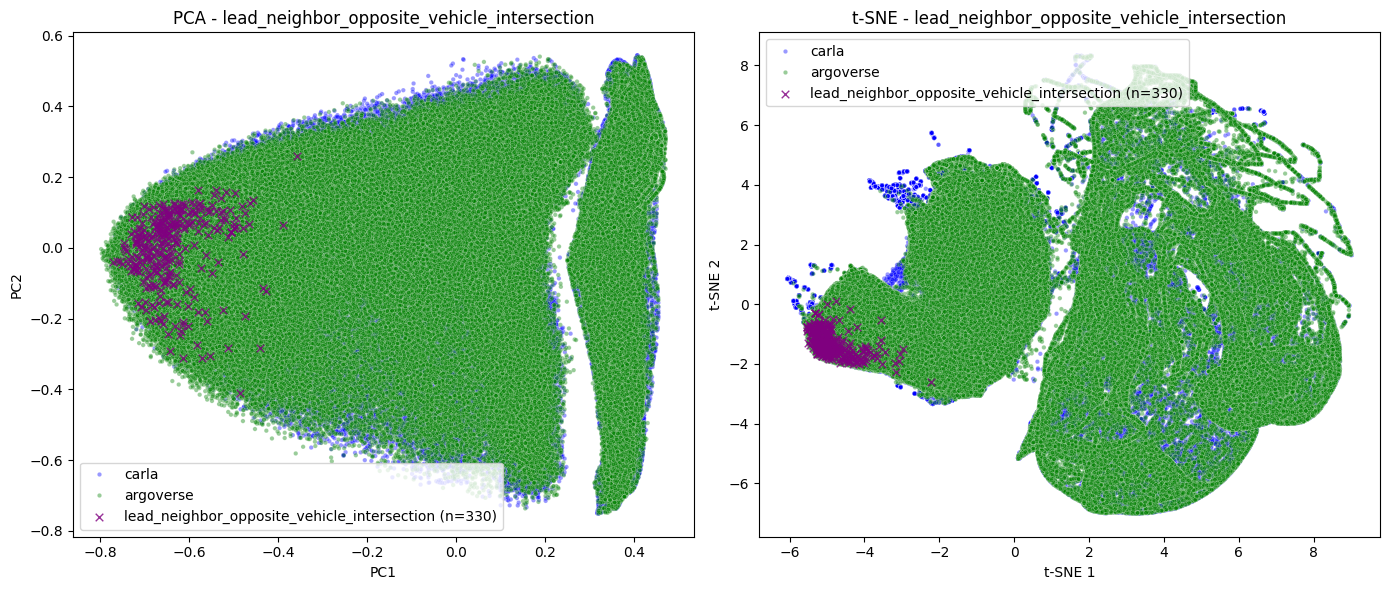

/tmp/ipykernel_800040/4167358975.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


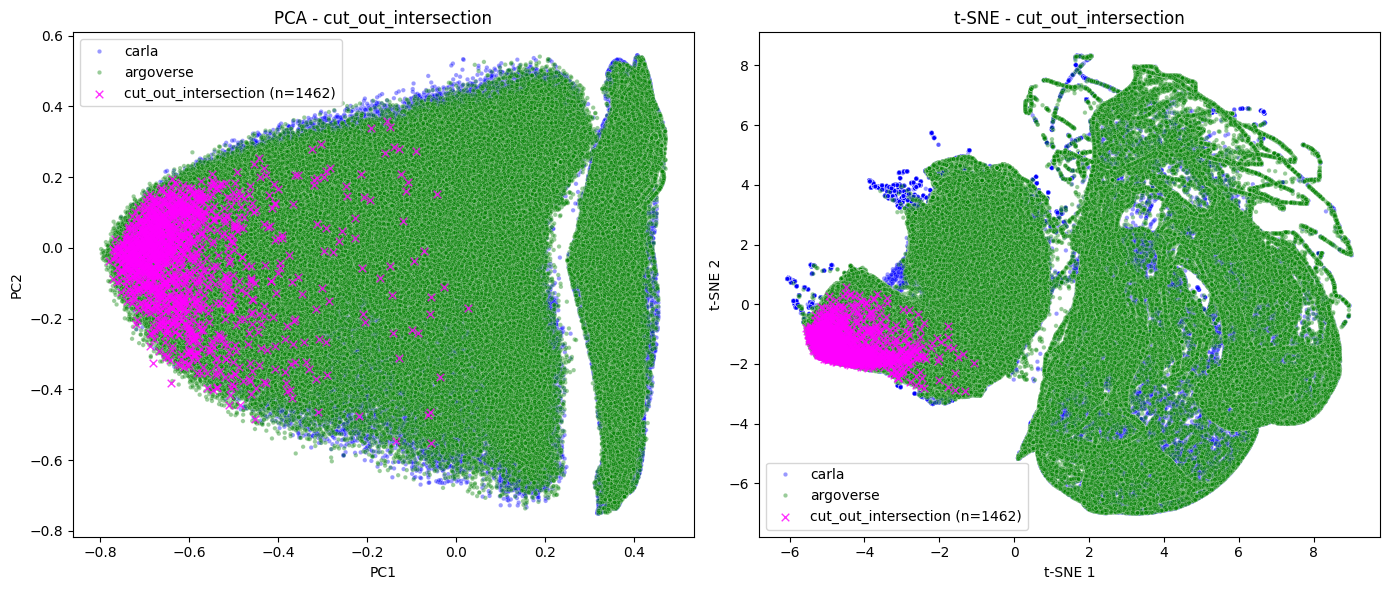

In [20]:
# Define colors and markers for each scenario
scenario_colors = {
    'cut_in': 'red',
    'cut_out': 'orange',
    'lead_neighbor_opposite_vehicle_intersection': 'purple',
    'cut_out_intersection': 'magenta'
}

# Create a plot for each scenario
for scenario in scenarios:
    df_scenario = df_gap[df_gap[scenario]]
    color = scenario_colors.get(scenario, 'red')
    
    plt.figure(figsize=(14, 6))
    
    # PCA plot
    plt.subplot(1, 2, 1)
    # Plot normal points first (background)
    sns.scatterplot(x="pca1", y="pca2", alpha=0.4, hue="graph_type", 
                    data=df_normal, s=10, palette={"carla": "blue", "argoverse": "green"})
    # Overlay scenario-specific coverage gap points
    plt.scatter(df_scenario["pca1"], df_scenario["pca2"], c=color, s=30, marker="x", 
                label=f"{scenario} (n={len(df_scenario)})", alpha=0.8, linewidths=1)
    plt.title(f'PCA - {scenario}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    
    # t-SNE plot
    plt.subplot(1, 2, 2)
    # Plot normal points first (background)
    sns.scatterplot(x="tsne1", y="tsne2", alpha=0.4, hue="graph_type", 
                    data=df_normal, s=10, palette={"carla": "blue", "argoverse": "green"})
    # Overlay scenario-specific coverage gap points
    plt.scatter(df_scenario["tsne1"], df_scenario["tsne2"], c=color, s=30, marker="x", 
                label=f"{scenario} (n={len(df_scenario)})", alpha=0.8, linewidths=1)
    plt.title(f't-SNE - {scenario}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    
    plt.tight_layout()
    # Save with scenario name (replace spaces with underscores)
    safe_scenario_name = scenario.replace(' ', '_')
    plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_coverage_gap_{safe_scenario_name}.png", dpi=150)
    plt.show()

### Coverage gap analysis

In [21]:
# Analyze where coverage gaps cluster
print("Coverage gap statistics:")
print(f"Total coverage gap graphs: {len(df_gap)}")
print(f"\nPCA ranges for coverage gaps:")
print(f"  PC1: [{df_gap['pca1'].min():.3f}, {df_gap['pca1'].max():.3f}]")
print(f"  PC2: [{df_gap['pca2'].min():.3f}, {df_gap['pca2'].max():.3f}]")
print(f"\nt-SNE ranges for coverage gaps:")
print(f"  t-SNE1: [{df_gap['tsne1'].min():.3f}, {df_gap['tsne1'].max():.3f}]")
print(f"  t-SNE2: [{df_gap['tsne2'].min():.3f}, {df_gap['tsne2'].max():.3f}]")

print(f"\n\nPer-scenario statistics:")
for scenario in scenarios:
    df_scenario = df_gap[df_gap[scenario]]
    print(f"\n{scenario} (n={len(df_scenario)}):")
    print(f"  PCA - PC1: [{df_scenario['pca1'].min():.3f}, {df_scenario['pca1'].max():.3f}]")
    print(f"  PCA - PC2: [{df_scenario['pca2'].min():.3f}, {df_scenario['pca2'].max():.3f}]")

Coverage gap statistics:
Total coverage gap graphs: 23148

PCA ranges for coverage gaps:
  PC1: [-0.791, 0.279]
  PC2: [-0.676, 0.414]

t-SNE ranges for coverage gaps:
  t-SNE1: [-5.596, 1.251]
  t-SNE2: [-3.157, 4.355]


Per-scenario statistics:

cut_in (n=21643):
  PCA - PC1: [-0.791, 0.279]
  PCA - PC2: [-0.676, 0.414]

cut_out (n=6653):
  PCA - PC1: [-0.787, 0.117]
  PCA - PC2: [-0.606, 0.365]

lead_neighbor_opposite_vehicle_intersection (n=330):
  PCA - PC1: [-0.773, -0.357]
  PCA - PC2: [-0.411, 0.260]

cut_out_intersection (n=1462):
  PCA - PC1: [-0.781, 0.026]
  PCA - PC2: [-0.552, 0.359]


### Cut-out Intersection Scenario: CARLA vs Argoverse Distribution Analysis

The following visualizations demonstrate that CARLA data has substantially lower representation in the `cut_out_intersection` coverage gap region compared to Argoverse data.

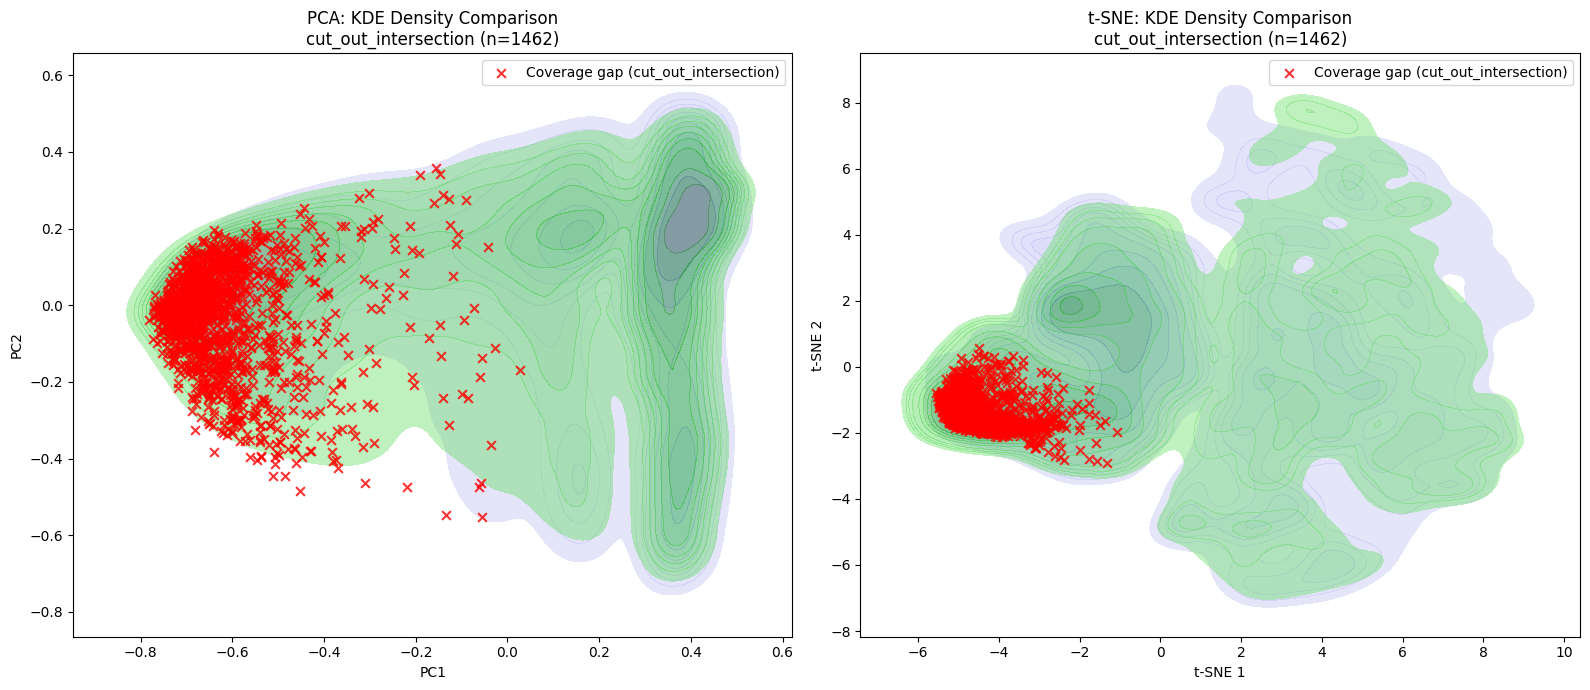

In [22]:
# 1. KDE Density Comparison Plot
# Shows overlaid density contours for CARLA vs Argoverse with coverage gap points highlighted

scenario_name = "cut_out_intersection"
df_scenario = df_gap[df_gap[scenario_name]]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA KDE plot
ax = axes[0]
# CARLA density
sns.kdeplot(x="pca1", y="pca2", data=dim_reduc_df[dim_reduc_df.graph_type == "carla"], 
            ax=ax, fill=True, alpha=0.4, label="CARLA", color="blue", levels=10)
# Argoverse density
sns.kdeplot(x="pca1", y="pca2", data=dim_reduc_df[dim_reduc_df.graph_type == "argoverse"], 
            ax=ax, fill=True, alpha=0.4, label="Argoverse", color="green", levels=10)
# Coverage gap points
ax.scatter(df_scenario["pca1"], df_scenario["pca2"], c="red", marker="x", s=40, 
           label=f"Coverage gap ({scenario_name})", alpha=0.8, linewidths=1.5, zorder=10)
ax.set_title(f'PCA: KDE Density Comparison\n{scenario_name} (n={len(df_scenario)})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# t-SNE KDE plot
ax = axes[1]
# CARLA density
sns.kdeplot(x="tsne1", y="tsne2", data=dim_reduc_df[dim_reduc_df.graph_type == "carla"], 
            ax=ax, fill=True, alpha=0.4, label="CARLA", color="blue", levels=10)
# Argoverse density
sns.kdeplot(x="tsne1", y="tsne2", data=dim_reduc_df[dim_reduc_df.graph_type == "argoverse"], 
            ax=ax, fill=True, alpha=0.4, label="Argoverse", color="green", levels=10)
# Coverage gap points
ax.scatter(df_scenario["tsne1"], df_scenario["tsne2"], c="red", marker="x", s=40, 
           label=f"Coverage gap ({scenario_name})", alpha=0.8, linewidths=1.5, zorder=10)
ax.set_title(f't-SNE: KDE Density Comparison\n{scenario_name} (n={len(df_scenario)})')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend()

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_{scenario_name}_kde_density.png", dpi=150)
plt.show()

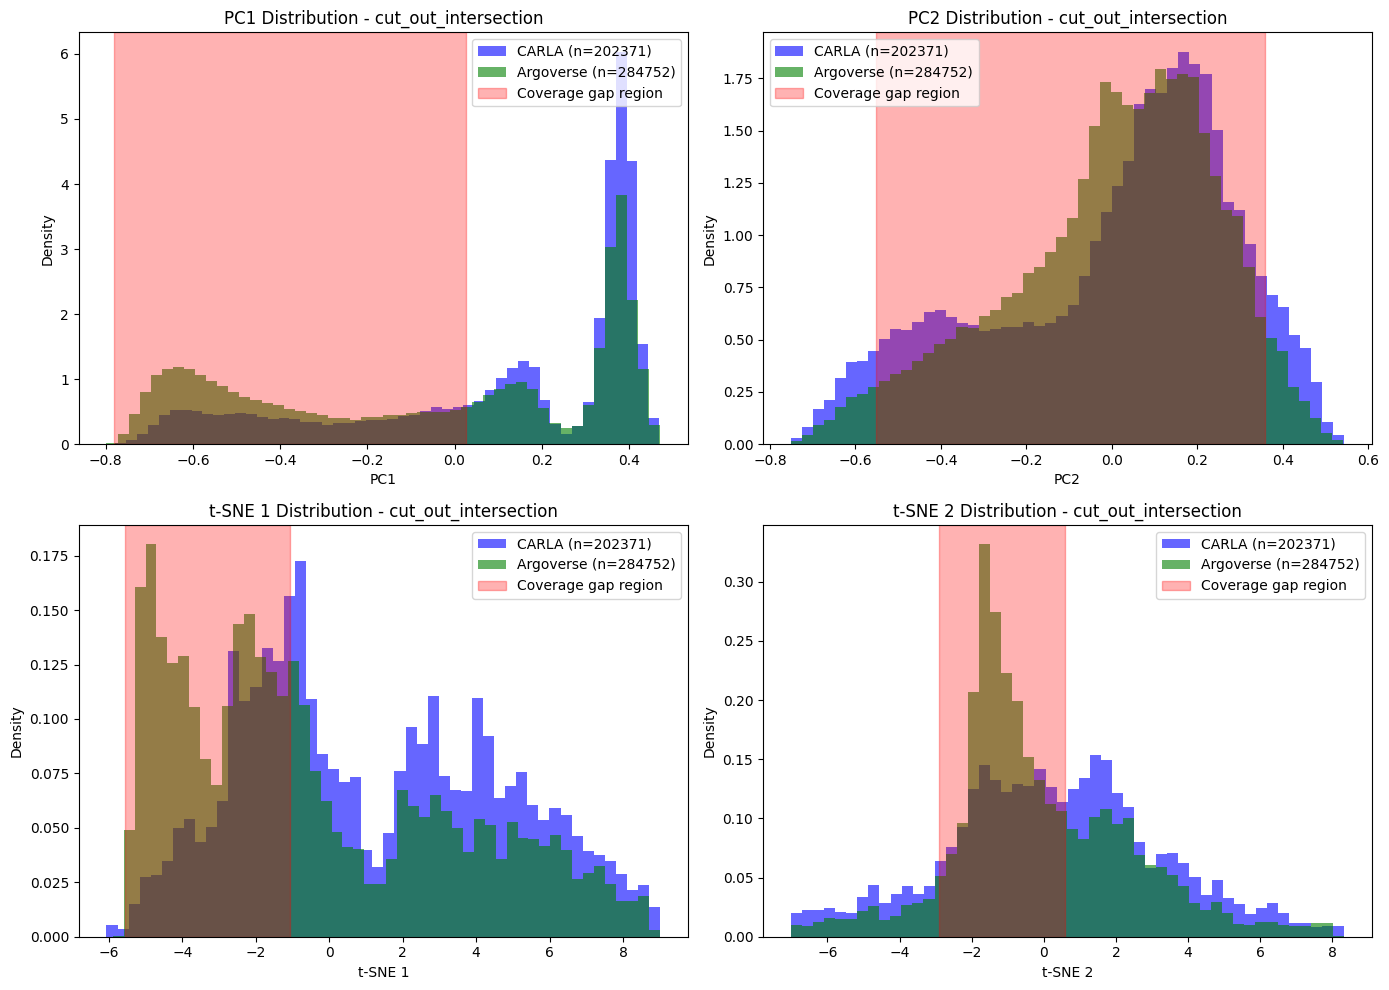

In [23]:
# 2. Histogram/Distribution Comparison Along Principal Axes
# Shows 1D histograms comparing CARLA vs Argoverse distributions along PC1/PC2 with coverage gap region shaded

scenario_name = "cut_out_intersection"
df_scenario = df_gap[df_gap[scenario_name]]

# Get bounds of the coverage gap region
gap_pca1_min, gap_pca1_max = df_scenario['pca1'].min(), df_scenario['pca1'].max()
gap_pca2_min, gap_pca2_max = df_scenario['pca2'].min(), df_scenario['pca2'].max()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Separate data by type
df_carla = dim_reduc_df[dim_reduc_df.graph_type == "carla"]
df_argoverse = dim_reduc_df[dim_reduc_df.graph_type == "argoverse"]

# PC1 histogram
ax = axes[0, 0]
ax.hist(df_carla['pca1'], bins=50, alpha=0.6, label=f'CARLA (n={len(df_carla)})', color='blue', density=True)
ax.hist(df_argoverse['pca1'], bins=50, alpha=0.6, label=f'Argoverse (n={len(df_argoverse)})', color='green', density=True)
ax.axvspan(gap_pca1_min, gap_pca1_max, alpha=0.3, color='red', label='Coverage gap region')
ax.set_xlabel('PC1')
ax.set_ylabel('Density')
ax.set_title(f'PC1 Distribution - {scenario_name}')
ax.legend()

# PC2 histogram
ax = axes[0, 1]
ax.hist(df_carla['pca2'], bins=50, alpha=0.6, label=f'CARLA (n={len(df_carla)})', color='blue', density=True)
ax.hist(df_argoverse['pca2'], bins=50, alpha=0.6, label=f'Argoverse (n={len(df_argoverse)})', color='green', density=True)
ax.axvspan(gap_pca2_min, gap_pca2_max, alpha=0.3, color='red', label='Coverage gap region')
ax.set_xlabel('PC2')
ax.set_ylabel('Density')
ax.set_title(f'PC2 Distribution - {scenario_name}')
ax.legend()

# t-SNE 1 histogram
gap_tsne1_min, gap_tsne1_max = df_scenario['tsne1'].min(), df_scenario['tsne1'].max()
gap_tsne2_min, gap_tsne2_max = df_scenario['tsne2'].min(), df_scenario['tsne2'].max()

ax = axes[1, 0]
ax.hist(df_carla['tsne1'], bins=50, alpha=0.6, label=f'CARLA (n={len(df_carla)})', color='blue', density=True)
ax.hist(df_argoverse['tsne1'], bins=50, alpha=0.6, label=f'Argoverse (n={len(df_argoverse)})', color='green', density=True)
ax.axvspan(gap_tsne1_min, gap_tsne1_max, alpha=0.3, color='red', label='Coverage gap region')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('Density')
ax.set_title(f't-SNE 1 Distribution - {scenario_name}')
ax.legend()

# t-SNE 2 histogram
ax = axes[1, 1]
ax.hist(df_carla['tsne2'], bins=50, alpha=0.6, label=f'CARLA (n={len(df_carla)})', color='blue', density=True)
ax.hist(df_argoverse['tsne2'], bins=50, alpha=0.6, label=f'Argoverse (n={len(df_argoverse)})', color='green', density=True)
ax.axvspan(gap_tsne2_min, gap_tsne2_max, alpha=0.3, color='red', label='Coverage gap region')
ax.set_xlabel('t-SNE 2')
ax.set_ylabel('Density')
ax.set_title(f't-SNE 2 Distribution - {scenario_name}')
ax.legend()

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_{scenario_name}_histogram.png", dpi=150)
plt.show()

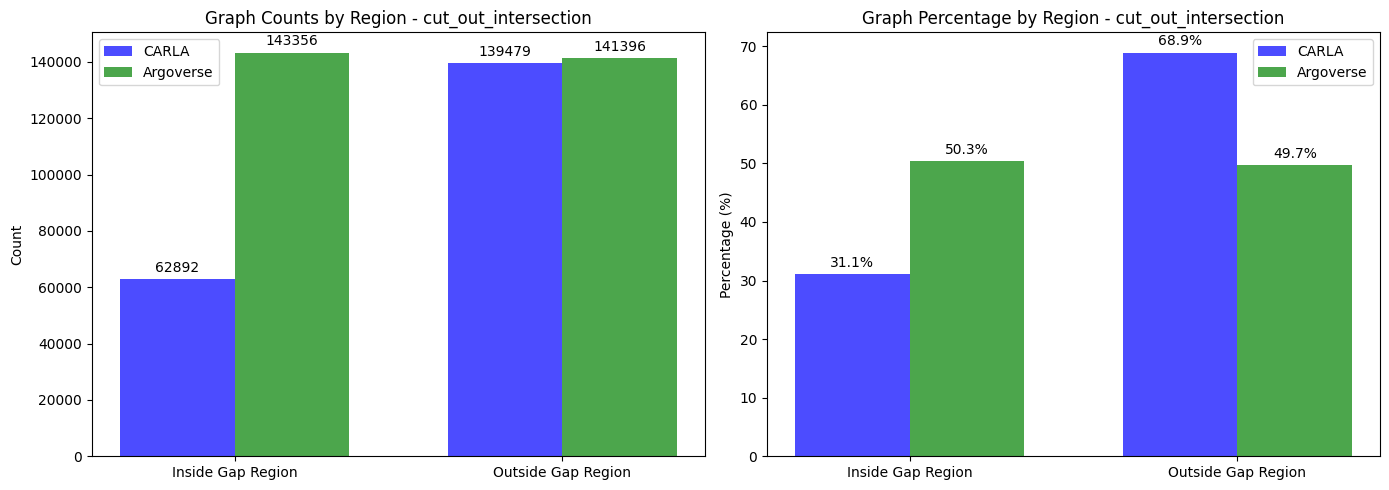


cut_out_intersection - Regional Distribution Summary:
  CARLA in gap region: 62,892 (31.08%)
  Argoverse in gap region: 143,356 (50.34%)
  Ratio (Argoverse/CARLA): 1.62x more Argoverse representation


In [24]:
# 3. Regional Density Bar Chart
# Shows a bar chart comparing CARLA vs Argoverse counts in the coverage gap region vs outside

scenario_name = "cut_out_intersection"
df_scenario = df_gap[df_gap[scenario_name]]

# Define the coverage gap region bounds (using PCA coordinates)
gap_pca1_min, gap_pca1_max = df_scenario['pca1'].min(), df_scenario['pca1'].max()
gap_pca2_min, gap_pca2_max = df_scenario['pca2'].min(), df_scenario['pca2'].max()

# Classify all points as inside or outside the coverage gap region
def is_in_gap_region(row):
    return (gap_pca1_min <= row['pca1'] <= gap_pca1_max) and (gap_pca2_min <= row['pca2'] <= gap_pca2_max)

dim_reduc_df['in_gap_region'] = dim_reduc_df.apply(is_in_gap_region, axis=1)

# Count by graph type and region
df_carla = dim_reduc_df[dim_reduc_df.graph_type == "carla"]
df_argoverse = dim_reduc_df[dim_reduc_df.graph_type == "argoverse"]

carla_in_gap = df_carla['in_gap_region'].sum()
carla_outside_gap = len(df_carla) - carla_in_gap
argoverse_in_gap = df_argoverse['in_gap_region'].sum()
argoverse_outside_gap = len(df_argoverse) - argoverse_in_gap

# Calculate percentages
carla_in_gap_pct = 100 * carla_in_gap / len(df_carla)
argoverse_in_gap_pct = 100 * argoverse_in_gap / len(df_argoverse)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts bar chart
ax = axes[0]
x = np.arange(2)
width = 0.35
bars1 = ax.bar(x - width/2, [carla_in_gap, carla_outside_gap], width, label='CARLA', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, [argoverse_in_gap, argoverse_outside_gap], width, label='Argoverse', color='green', alpha=0.7)
ax.set_ylabel('Count')
ax.set_title(f'Graph Counts by Region - {scenario_name}')
ax.set_xticks(x)
ax.set_xticklabels(['Inside Gap Region', 'Outside Gap Region'])
ax.legend()
ax.bar_label(bars1, padding=3, fmt='%d')
ax.bar_label(bars2, padding=3, fmt='%d')

# Percentage bar chart (normalized)
ax = axes[1]
bars1 = ax.bar(x - width/2, [carla_in_gap_pct, 100-carla_in_gap_pct], width, label='CARLA', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, [argoverse_in_gap_pct, 100-argoverse_in_gap_pct], width, label='Argoverse', color='green', alpha=0.7)
ax.set_ylabel('Percentage (%)')
ax.set_title(f'Graph Percentage by Region - {scenario_name}')
ax.set_xticks(x)
ax.set_xticklabels(['Inside Gap Region', 'Outside Gap Region'])
ax.legend()
ax.bar_label(bars1, padding=3, fmt='%.1f%%')
ax.bar_label(bars2, padding=3, fmt='%.1f%%')

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_{scenario_name}_bar_chart.png", dpi=150)
plt.show()

# Print summary statistics
print(f"\n{scenario_name} - Regional Distribution Summary:")
print(f"  CARLA in gap region: {carla_in_gap:,} ({carla_in_gap_pct:.2f}%)")
print(f"  Argoverse in gap region: {argoverse_in_gap:,} ({argoverse_in_gap_pct:.2f}%)")
print(f"  Ratio (Argoverse/CARLA): {argoverse_in_gap_pct/carla_in_gap_pct:.2f}x more Argoverse representation")

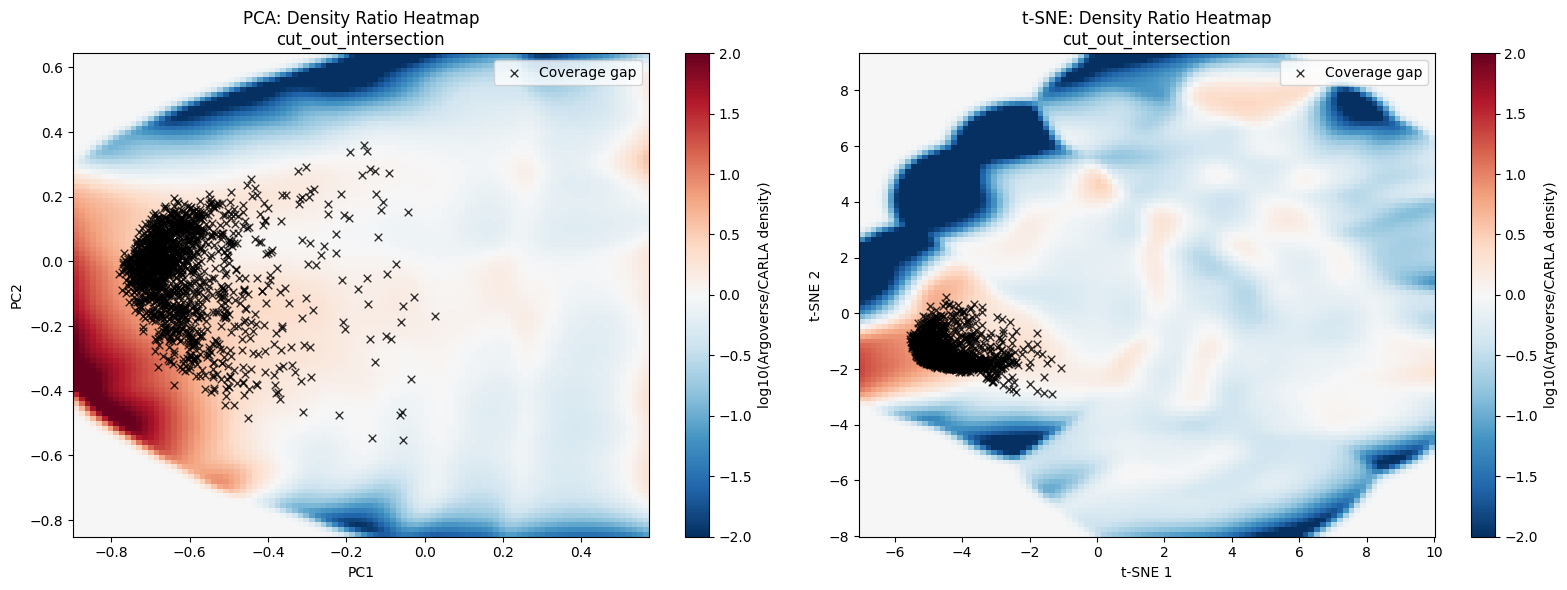

Note: Red regions indicate higher Argoverse density relative to CARLA (coverage gaps)
      Blue regions indicate higher CARLA density relative to Argoverse


In [25]:
# 4. Density Ratio Heatmap
# Shows a heatmap of log(density_argoverse / density_carla) - high values indicate coverage gaps

from scipy.stats import gaussian_kde

scenario_name = "cut_out_intersection"
df_scenario = df_gap[df_gap[scenario_name]]

# Separate data by type
df_carla = dim_reduc_df[dim_reduc_df.graph_type == "carla"]
df_argoverse = dim_reduc_df[dim_reduc_df.graph_type == "argoverse"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA density ratio heatmap
ax = axes[0]

# Create a grid for evaluation
x_min, x_max = dim_reduc_df['pca1'].min() - 0.1, dim_reduc_df['pca1'].max() + 0.1
y_min, y_max = dim_reduc_df['pca2'].min() - 0.1, dim_reduc_df['pca2'].max() + 0.1
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDE for each dataset
carla_values = np.vstack([df_carla['pca1'].values, df_carla['pca2'].values])
argoverse_values = np.vstack([df_argoverse['pca1'].values, df_argoverse['pca2'].values])

kde_carla = gaussian_kde(carla_values)
kde_argoverse = gaussian_kde(argoverse_values)

z_carla = np.reshape(kde_carla(positions).T, xx.shape)
z_argoverse = np.reshape(kde_argoverse(positions).T, xx.shape)

# Compute log ratio (with small epsilon to avoid division by zero)
epsilon = 1e-10
log_ratio = np.log10((z_argoverse + epsilon) / (z_carla + epsilon))

# Plot heatmap
im = ax.imshow(log_ratio.T, origin='lower', aspect='auto', 
               extent=[x_min, x_max, y_min, y_max], cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar(im, ax=ax, label='log10(Argoverse/CARLA density)')

# Overlay coverage gap points
ax.scatter(df_scenario["pca1"], df_scenario["pca2"], c="black", marker="x", s=30, 
           label=f"Coverage gap", alpha=0.8, linewidths=1)
ax.set_title(f'PCA: Density Ratio Heatmap\n{scenario_name}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

# t-SNE density ratio heatmap
ax = axes[1]

# Create a grid for evaluation
x_min, x_max = dim_reduc_df['tsne1'].min() - 1, dim_reduc_df['tsne1'].max() + 1
y_min, y_max = dim_reduc_df['tsne2'].min() - 1, dim_reduc_df['tsne2'].max() + 1
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDE for each dataset
carla_values = np.vstack([df_carla['tsne1'].values, df_carla['tsne2'].values])
argoverse_values = np.vstack([df_argoverse['tsne1'].values, df_argoverse['tsne2'].values])

kde_carla = gaussian_kde(carla_values)
kde_argoverse = gaussian_kde(argoverse_values)

z_carla = np.reshape(kde_carla(positions).T, xx.shape)
z_argoverse = np.reshape(kde_argoverse(positions).T, xx.shape)

# Compute log ratio
log_ratio = np.log10((z_argoverse + epsilon) / (z_carla + epsilon))

# Plot heatmap
im = ax.imshow(log_ratio.T, origin='lower', aspect='auto', 
               extent=[x_min, x_max, y_min, y_max], cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar(im, ax=ax, label='log10(Argoverse/CARLA density)')

# Overlay coverage gap points
ax.scatter(df_scenario["tsne1"], df_scenario["tsne2"], c="black", marker="x", s=30, 
           label=f"Coverage gap", alpha=0.8, linewidths=1)
ax.set_title(f't-SNE: Density Ratio Heatmap\n{scenario_name}')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend()

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_{scenario_name}_density_ratio.png", dpi=150)
plt.show()

print("Note: Red regions indicate higher Argoverse density relative to CARLA (coverage gaps)")
print("      Blue regions indicate higher CARLA density relative to Argoverse")

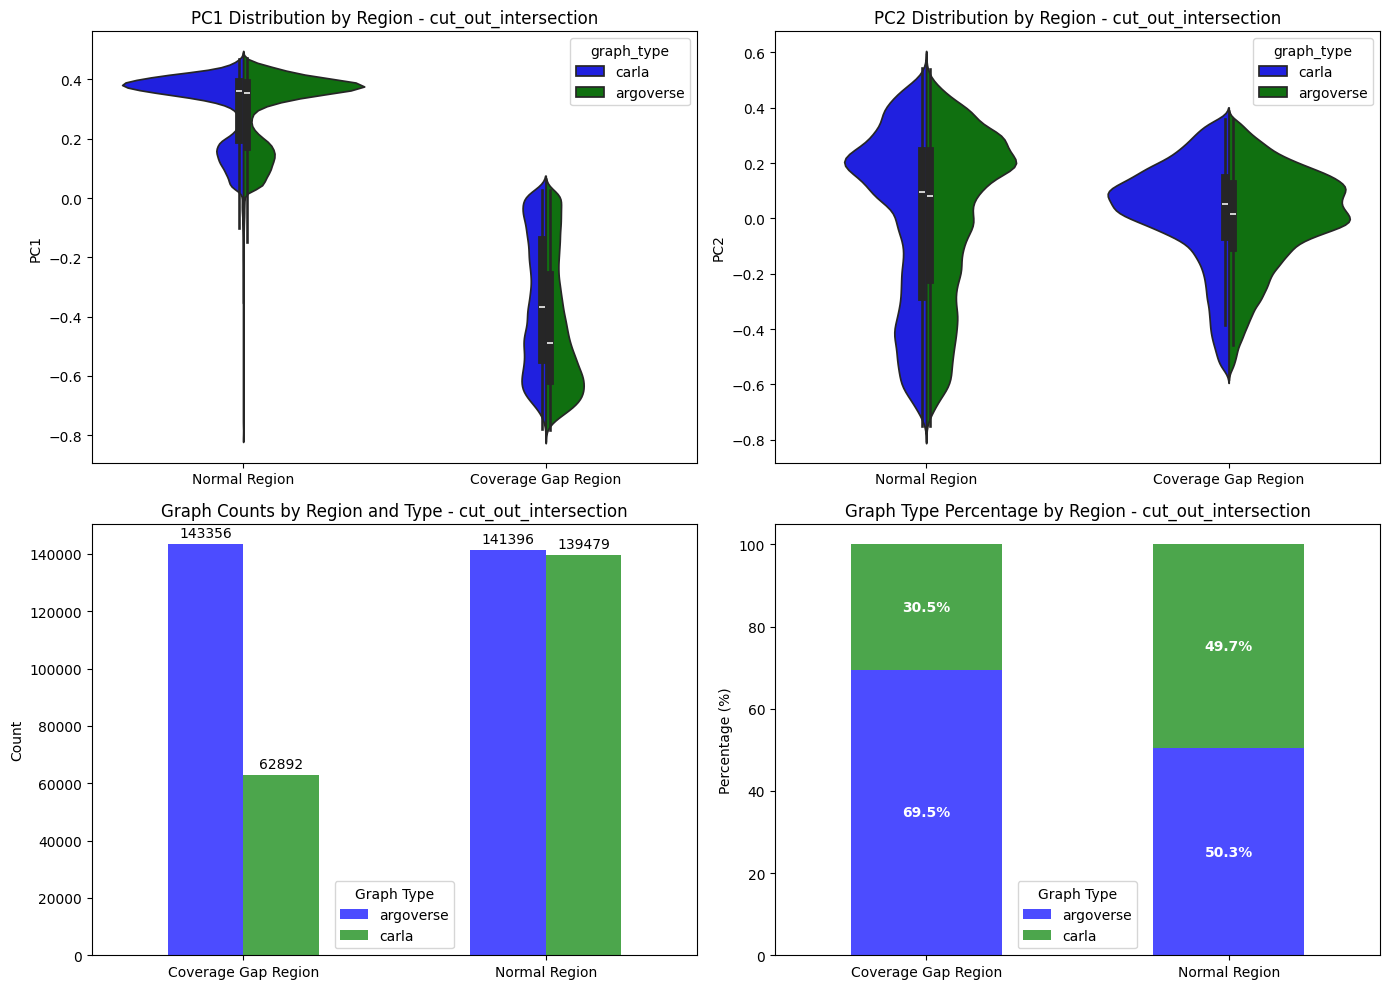


cut_out_intersection - Detailed Statistics:

Counts by region and type:
graph_type           argoverse   carla
region                                
Coverage Gap Region     143356   62892
Normal Region           141396  139479

Percentages by region:
graph_type           argoverse  carla
region                               
Coverage Gap Region      69.51  30.49
Normal Region            50.34  49.66


In [26]:
# 5. Violin/Box Plot by Region
# Shows violin plots comparing CARLA vs Argoverse distributions in coverage gap region vs normal region

scenario_name = "cut_out_intersection"
df_scenario = df_gap[df_gap[scenario_name]]

# Use the in_gap_region column created earlier (or recreate if needed)
if 'in_gap_region' not in dim_reduc_df.columns:
    gap_pca1_min, gap_pca1_max = df_scenario['pca1'].min(), df_scenario['pca1'].max()
    gap_pca2_min, gap_pca2_max = df_scenario['pca2'].min(), df_scenario['pca2'].max()
    def is_in_gap_region(row):
        return (gap_pca1_min <= row['pca1'] <= gap_pca1_max) and (gap_pca2_min <= row['pca2'] <= gap_pca2_max)
    dim_reduc_df['in_gap_region'] = dim_reduc_df.apply(is_in_gap_region, axis=1)

# Create a region label
dim_reduc_df['region'] = dim_reduc_df['in_gap_region'].map({True: 'Coverage Gap Region', False: 'Normal Region'})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Violin plot for PC1
ax = axes[0, 0]
sns.violinplot(data=dim_reduc_df, x='region', y='pca1', hue='graph_type', 
               split=True, ax=ax, palette={"carla": "blue", "argoverse": "green"})
ax.set_title(f'PC1 Distribution by Region - {scenario_name}')
ax.set_xlabel('')
ax.set_ylabel('PC1')

# Violin plot for PC2
ax = axes[0, 1]
sns.violinplot(data=dim_reduc_df, x='region', y='pca2', hue='graph_type', 
               split=True, ax=ax, palette={"carla": "blue", "argoverse": "green"})
ax.set_title(f'PC2 Distribution by Region - {scenario_name}')
ax.set_xlabel('')
ax.set_ylabel('PC2')

# Box plot comparison - counts per region
ax = axes[1, 0]
region_counts = dim_reduc_df.groupby(['region', 'graph_type']).size().unstack(fill_value=0)
region_counts.plot(kind='bar', ax=ax, color=['blue', 'green'], alpha=0.7)
ax.set_title(f'Graph Counts by Region and Type - {scenario_name}')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Graph Type')

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

# Stacked percentage bar chart
ax = axes[1, 1]
region_pcts = region_counts.div(region_counts.sum(axis=1), axis=0) * 100
region_pcts.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'green'], alpha=0.7)
ax.set_title(f'Graph Type Percentage by Region - {scenario_name}')
ax.set_xlabel('')
ax.set_ylabel('Percentage (%)')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Graph Type')

# Add percentage labels
for i, (idx, row) in enumerate(region_pcts.iterrows()):
    cumsum = 0
    for j, val in enumerate(row):
        ax.text(i, cumsum + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
        cumsum += val

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_{scenario_name}_violin_box.png", dpi=150)
plt.show()

# Print detailed statistics
print(f"\n{scenario_name} - Detailed Statistics:")
print("\nCounts by region and type:")
print(region_counts)
print("\nPercentages by region:")
print(region_pcts.round(2))